<a href="https://colab.research.google.com/github/anjali88/Basic-ML-/blob/master/Event_tracker_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
import sklearn

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
!pip install pyti

In [36]:
#upload dataset
from google.colab import files
uploaded = files.upload()

Saving data_second.xlsx to data_second (2).xlsx


In [0]:
!pip install mxnet

In [37]:
import io
df = pd.read_excel(io.BytesIO(uploaded['data_second.xlsx']))
# Dataset is now stored in a Pandas Dataframe
#print the head
df.head()

,Dates,Open,Close,High,Low,Value,Volume
0,2018-02-14 08:00:00,1682.0,1679.8,1682.0,1677.6,36935376.0,21978
1,2018-02-14 08:01:00,1679.8,1680.8,1681.6,1678.0,28434078.0,16930
2,2018-02-14 08:02:00,1681.2,1679.0,1681.2,1678.0,24295556.0,14466
3,2018-02-14 08:03:00,1679.0,1675.6,1679.8,1675.4,19602172.0,11683
4,2018-02-14 08:04:00,1674.6,1676.4,1677.4,1674.6,10772108.0,6427


There are multiple variables in the dataset – dates, open, close, high, low, value, and volume.
The columns Open and Close represent the starting and final price at which the stock is traded on a particular day.
High, Low represent the maximum and minimum price of the share for the day.
Volume is the number of shares bought or sold in the day and Value is the turnover of the particular company on a given date.

The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable. Let’s plot the target variable to understand how it’s shaping up in our data:

In [38]:
!ls "/content/drive/My Drive/Colab Notebooks"

 arima_analysys.py		  __pycache__
 conver_xlsx.py			  sample_event.py
'Copy of Copy of 01. SVM.ipynb'   sample.py
'Copy of ET-ML.ipynb'		  sensitivity_analysis_api.py
'Copy of Event_tracker_1.ipynb'   sensitivity_analysis_basic.py
'Copy of Untitled6.ipynb'	  sensitivity_analysis_multi.py
 data_second.xlsx		  sensitivity_analysis.py
 deep_learning_model.py		  sensitivity_analysis_threshold.py
 et.py				  sobel.py
 Event_tracker_2.ipynb		  Sobol_G.txt
 event_tracker_v1.py		  support_vector_regression.py
 graphs				  technical_indicator_data.py
 HFT_Event_Tracker		  technical_indicator_matrix.py
 keras_reg.py			  technical_indicators_manual_calculation.py
 morries.py			  technical_indicators.py
 Oxford-ML			  Untitled
 pearson.py			  Untitled8.ipynb


In [0]:
!python3 "/content/drive/My Drive/Colab Notebooks/sample_event.py" data_second.xlsx

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)



 Shape of the data:
(50, 7)


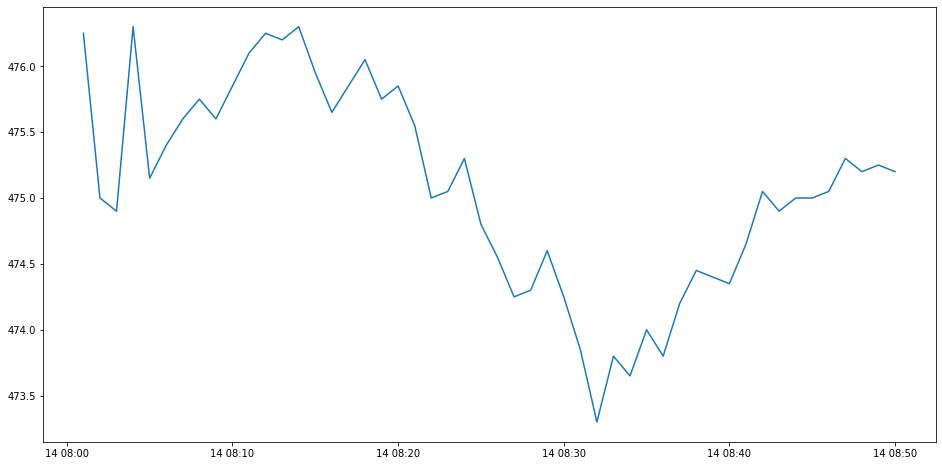

In [0]:
#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
#setting index as date
df['Dates'] = pd.to_datetime(df.Dates,format='%Y-%m-%d')
df.index = df['Dates']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

print('\n Shape of the data:')
print(df.shape)

In [0]:
print('There are {} number of days in the dataset.'.format(df.shape[0]))

There are 50 number of days in the dataset.


In [0]:
#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Dates', 'Close'])

for i in range(0,len(data)):
     new_data['Dates'][i] = data['Dates'][i]
     new_data['Close'][i] = data['Close'][i]
     # splitting into train and validation
     # NOTE: While splitting the data into train and validation set, we cannot use random splitting since that will destroy the time component. 
train = new_data[:35]
valid = new_data[35:]

# shapes of training set
print('\n Shape of training set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)


 Shape of training set:
(35, 2)

 Shape of validation set:
(15, 2)


In [0]:
# NOTE: While splitting the data into train and validation set, we cannot use random splitting since that will destroy the time component. 

# In the next step, we will create predictions for the validation set and check the RMSE using the actual values.
# making predictions
preds = []
for i in range(0,valid.shape[0]):
    a = train['Close'][len(train)-15+i:].sum() + sum(preds)
    b = a/15
    preds.append(b)

# checking the results (RMSE value)
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
print('\n RMSE value on validation set:')
print(rms)


 RMSE value on validation set:
0.8243689069740834


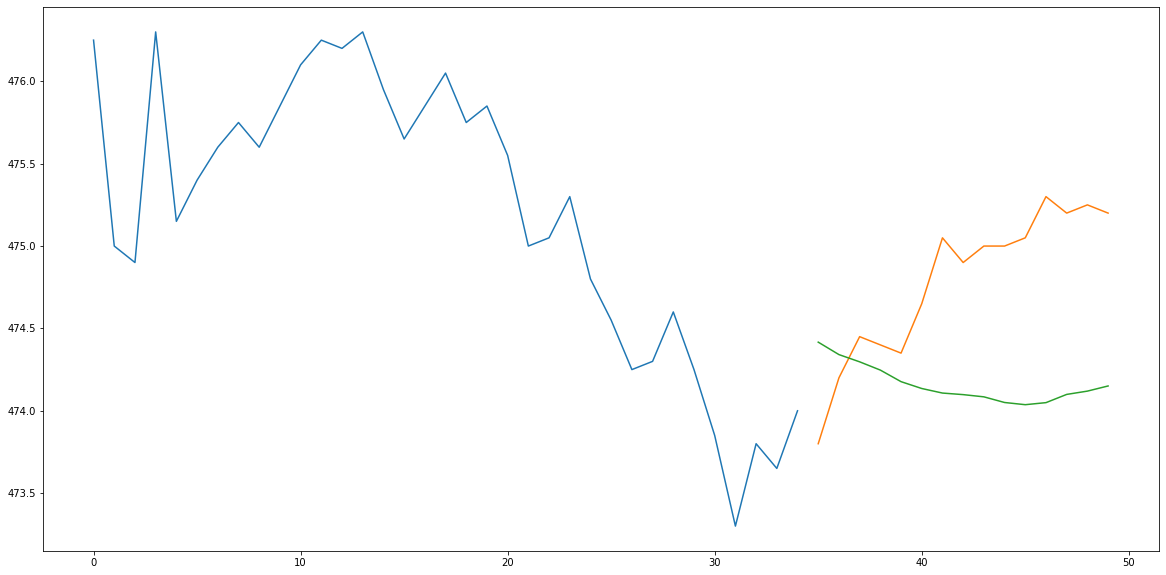

In [0]:
import warnings
warnings.filterwarnings("ignore")
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

In [0]:
### Import all appropritae libararies ###
import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx

import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")